In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [3]:
stk = pd.read_csv("../data/train_processed_upsampled.csv")
stk.head()

,stroke_in_2018,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,0,71.67,36.6,61.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,107.95,30.4,30.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,76.49,42.1,51.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,113.98,57.3,54.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,70.60,26.7,27.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
X = stk.drop(labels="stroke_in_2018", axis=1).reset_index(drop=True)
y = stk["stroke_in_2018"].reset_index(drop=True)

In [25]:
X.head()

,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,married_1,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,71.67,36.6,61.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,107.95,30.4,30.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,76.49,42.1,51.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,113.98,57.3,54.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,70.60,26.7,27.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [26]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: stroke_in_2018, dtype: int64

Let's normalise the variables and see if that helps

In [44]:
X_norm = X.copy()

In [47]:
def norm_cols(df, col_names):
    """
    
    Parameters
    ----------
    
    df: a copy of the training set, no labels, non-normalised columns will be overwritten
    col_names: array of col_names to be normalised
    
    """
    
    min_max_scaler = preprocessing.MinMaxScaler()
    
    for col in col_names:
        x_np = np.array(df[col]) # returns a numpy array
        x_scaled = min_max_scaler.fit_transform(x_np.reshape(-1, 1))
        x_scaled = [x[0] for x in x_scaled]
        
        df[col] = x_scaled

In [48]:
norm_cols(X_norm, ["average_blood_sugar", "BMI", "age_corr"])

In [50]:
X_norm.head()

,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,married_1,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,0.051093,0.298718,0.666667,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.204796,0.219231,0.236111,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.071513,0.369231,0.527778,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.230342,0.564103,0.569444,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.046560,0.171795,0.194444,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Building Base Models

Now we proceed to build base models. We will consider:

- KNN-models, SVM (with penalised regression)
- Linear regression family (OLS, Lasso, Ridge, ElasticNet etc.)
- Tree-based (XGBoost, LGB, RandomForest etc.)

We will look at the ROC-AUC curve to determine the best model, and the F1-score, which considers both precision and recall

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet, HuberRegressor, LinearRegression, Ridge, Lasso, SGDRegressor, PassiveAggressiveRegressor


### Tree Based Models

In [12]:
from operator import itemgetter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

In [17]:
tree_based_models = {
    "dt": DecisionTreeRegressor(),
    "rf": RandomForestRegressor(),
    "ada": AdaBoostRegressor(),
    "gb": GradientBoostingRegressor(),
    "et": ExtraTreesRegressor(),
    "xgb": XGBRegressor(),
#     "lgb": LGBMRegressor()
}

Because we are not yet interested in validation, we do not conduct any cross-validation when training the models. The purpose of this is to identify features which are important for 

In [51]:
for _, clf in tree_based_models.items():
    clf.fit(X_norm, y)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [52]:
def generate_sorted_feature_importance(columns_name, feature_importances):
    feature_importance_map = {}
    for i in range(len(columns_name)):
        feature_importance_map[columns_name[i]] = feature_importances[i]
    sorted_feature_importance = dict(sorted(feature_importance_map.items(), key=itemgetter(1)))
    return sorted_feature_importance

def plot_feature_importance(sorted_feature_importance, ax, title):
    num_feature = 20
    bp = sns.barplot(list(sorted_feature_importance.keys())[-num_feature:], list(sorted_feature_importance.values())[-num_feature:], ax=ax)
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
    bp.set_title(title)
    return bp

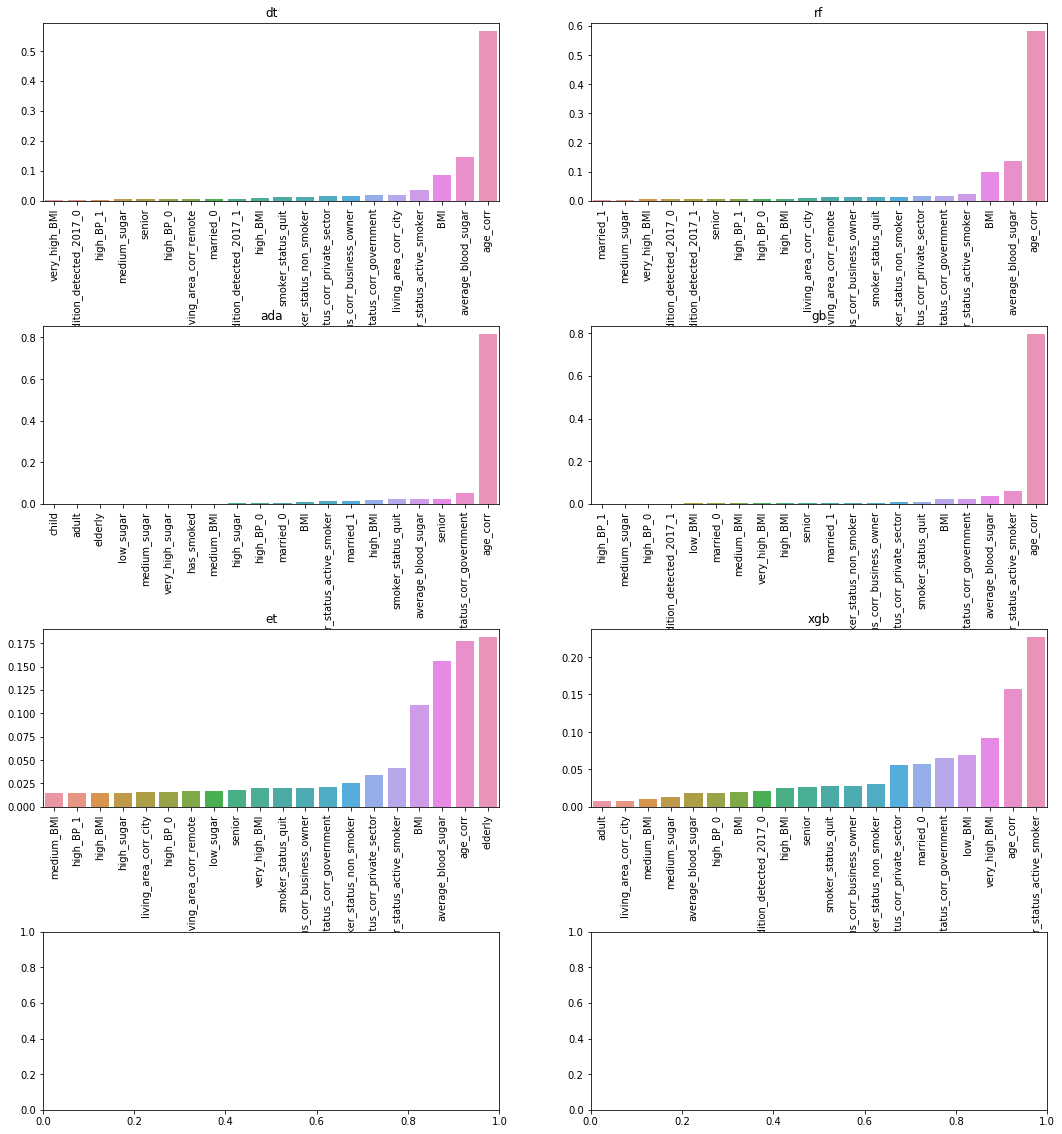

In [53]:
# to visualize the 20 most important features of each tree-based models
fig, axes = plt.subplots(4, 2)
fig.set_figheight(20)
fig.set_figwidth(18)
fig.subplots_adjust(hspace=0.7)
count = 0
for name, clf in tree_based_models.items():
    row = count // 2
    column = count % 2
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, clf.feature_importances_)
    plot_feature_importance(sorted_feature_importance, axes[row, column], name)
    count += 1

In [54]:
clf_features_importance = pd.DataFrame()
for name, clf in tree_based_models.items():
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, clf.feature_importances_)
    clf_features_importance[name] = list(sorted_feature_importance.keys())

In [55]:
clf_features_importance[-10:]

,dt,rf,ada,gb,et,xgb
22,smoker_status_quit,living_area_corr_remote,married_0,married_1,smoker_status_quit,smoker_status_quit
23,smoker_status_non_smoker,job_status_corr_business_owner,BMI,smoker_status_non_smoker,job_status_corr_business_owner,job_status_corr_business_owner
24,job_status_corr_private_sector,smoker_status_quit,smoker_status_active_smoker,job_status_corr_business_owner,job_status_corr_government,smoker_status_non_smoker
25,job_status_corr_business_owner,smoker_status_non_smoker,married_1,job_status_corr_private_sector,smoker_status_non_smoker,job_status_corr_private_sector
26,job_status_corr_government,job_status_corr_private_sector,high_BMI,smoker_status_quit,job_status_corr_private_sector,married_0
27,living_area_corr_city,job_status_corr_government,smoker_status_quit,BMI,smoker_status_active_smoker,job_status_corr_government
28,smoker_status_active_smoker,smoker_status_active_smoker,average_blood_sugar,job_status_corr_government,BMI,low_BMI
29,BMI,BMI,senior,average_blood_sugar,average_blood_sugar,very_high_BMI
30,average_blood_sugar,average_blood_sugar,job_status_corr_government,smoker_status_active_smoker,age_corr,age_corr
31,age_corr,age_corr,age_corr,age_corr,elderly,smoker_status_active_smoker
